**DATOS BASE**

Descargamos del [EFFIS](https://forest-fire.emergency.copernicus.eu/) (European Forest Fire Information System) la superficie quemada en formato shapefile:
- [Burn Areas database](https://maps.effis.emergency.copernicus.eu/effis?service=WFS&request=getfeature&typename=ms:modis.ba.poly&version=1.1.0&outputformat=SHAPEZIP)

Descargamos de eurostat ([GISCO](https://ec.europa.eu/eurostat/web/gisco/overview)) dos shapefile:
- [Countries](https://ec.europa.eu/eurostat/web/gisco/geodata/administrative-units/countries) - para obtener el nombre en inglés de los países y sus códigos internacionales
- [NUTS](https://ec.europa.eu/eurostat/web/gisco/geodata/statistical-units/territorial-units-statistics) (nomenclature of territorial units for statistics) - 
para obtener los polígonos de las regiones de cada país. En este shape los nombres aparecen en latín

In [1]:
import datetime as dt
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargamos el shapefile del EFFIS con geopandas

windows = r'C:\Users\Usuario\Downloads\effis_layer\modis.ba.poly.shp'
linux = '~/Descargas/effis_layer/modis.ba.poly.shp'

shp_effis = gpd.read_file(linux)
shp_effis.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry
0,264477,2000-09-20 00:00:00,2025-03-28 15:01:38.620495,EL,??????,???????? ????????? ?????,981,2.1472392638034616,0,0,5.4192229038849264,73.51738241308041,1.431492842535641,16.46216768915987,1.0224948875254578,0,32.02719647413729,FireSeason,"POLYGON ((24.10056 38.66232, 24.10079 38.65254..."
1,260352,2000-07-31 00:00:00,2000-12-31 12:10:11.414,IT,Crotone,Roccabernarda,56,0,0,0,0,0,58.49056603762549,41.50943396218583,0,0,99.99999999999997,FireSeason,"POLYGON ((16.84555 39.15941, 16.84656 39.15743..."
2,260396,2000-08-25 00:00:00,2000-12-31 12:10:11.414,IT,Crotone,Pallagorio,413,61.36919315401923,0,0,0,0,0,38.63080684595633,0,0,98.7552636258531,FireSeason,"POLYGON ((16.89034 39.33069, 16.89195 39.32436..."
3,260398,2000-07-15 00:00:00,2000-12-31 12:10:11.414,IT,Cosenza,Corigliano-Rossano,88,43.678160919490026,0,0,0,0,0,56.32183908039503,0,0,0,FireSeason,"POLYGON ((16.70885 39.57951, 16.71165 39.57865..."
4,259734,2000-09-02 00:00:00,2000-12-31 12:10:11.414,PT,Beiras e Serra da Estrela,Alvendre,54,0,0,0,0,21.81818181814215,45.45454545446281,32.727272727213226,0,0,0,FireSeason,"POLYGON ((-7.2476 40.59114, -7.24515 40.59178,..."


In [3]:
# Comprobamos que todos los campos son strings: no se reconcen números ni fechas

shp_effis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 92772 entries, 0 to 92771
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          92772 non-null  object  
 1   FIREDATE    92772 non-null  object  
 2   LASTUPDATE  92772 non-null  object  
 3   COUNTRY     92764 non-null  object  
 4   PROVINCE    92772 non-null  object  
 5   COMMUNE     92772 non-null  object  
 6   AREA_HA     92772 non-null  object  
 7   BROADLEA    92121 non-null  object  
 8   CONIFER     92121 non-null  object  
 9   MIXED       92121 non-null  object  
 10  SCLEROPH    92121 non-null  object  
 11  TRANSIT     92121 non-null  object  
 12  OTHERNATLC  92121 non-null  object  
 13  AGRIAREAS   92121 non-null  object  
 14  ARTIFSURF   92121 non-null  object  
 15  OTHERLC     92121 non-null  object  
 16  PERCNA2K    92772 non-null  object  
 17  CLASS       92772 non-null  object  
 18  geometry    92772 non-null  geometry
d

**FILTRO DE GRANDES INCENDIOS**

In [4]:
# Comprobamos que el 75% de los 'incendios' presentes en EFFIS tiene una superficie < 119 ha

shp_effis.AREA_HA.astype(int).describe()

count    92772.000000
mean       187.387121
std       1032.621209
min          0.000000
25%         13.000000
50%         40.000000
75%        119.000000
max      96610.000000
Name: AREA_HA, dtype: float64

In [5]:
# Filtramos los grandes incendios forestales, esto es, a partir de 500 ha

shp_effis.AREA_HA = shp_effis.AREA_HA.astype(int)
effis = shp_effis[shp_effis.AREA_HA > 499]

**FORMATO FECHA, DURACIÓN Y DIAS JULIANOS**

In [6]:
# Pasamos las columnas de inicio de incendio y última actualización a datetime 
effis.FIREDATE = pd.to_datetime(effis.FIREDATE, format='ISO8601')
effis.LASTUPDATE = pd.to_datetime(effis.LASTUPDATE, format='ISO8601')

# Eliminamos los incendios de 2025
effis = effis[effis.FIREDATE.dt.year < 2025]

# Calculamos la duración del incendio
effis['DURATION'] = effis.LASTUPDATE - effis.FIREDATE

/usr/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
# Calculamos el día juliano pero como si todos los años fueran bisiestos

def dia_juliano_bisiesto(serie):
    dias_meses = [0,31,29,31,30,31,30,31,31,30,31,30]
    lista_dias = []
    for valor in serie:
        dia_juliano = 0
        mes = valor.month
        for index in range(mes):
            dia_juliano += dias_meses[index]
        dia_juliano += valor.day
        lista_dias.append(dia_juliano)
    return lista_dias

effis['DAY_YEAR'] = dia_juliano_bisiesto(effis.FIREDATE)

**CALCULO DEL CENTROIDE Y COORDENADAS**

In [8]:
# Reproyectamos capa, calculamos centroides y extraemos coordenadas
effis = effis.to_crs(4326)
effis['LAT'], effis['LON'] = effis.centroid.y, effis.centroid.x

/tmp/ipykernel_2730/1526620908.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  effis['LAT'], effis['LON'] = effis.centroid.y, effis.centroid.x


In [9]:
# Comprobamos longitud para las islas atlánticas

effis[effis.LON < -11].groupby('COUNTRY').PROVINCE.value_counts()

COUNTRY  PROVINCE                  
ES       La Palma                       7
         Gran Canaria                   5
         Tenerife                       5
         La Gomera                      1
PT       Região Autónoma da Madeira    11
Name: count, dtype: int64

In [ ]:
# Comprobamos latitud para isla La Rèunion (Francia)

effis[effis.LAT < 0].groupby('COUNTRY').PROVINCE.value_counts()

COUNTRY  PROVINCE  
FR       La Réunion    1
Name: count, dtype: int64

In [11]:
# Eliminamos islas menores y archipiélagos

effis = effis.loc[(effis.LAT > 0) & (effis.LON > -11), :]

**FILTRO DE PAÍSES UE Y ENTORNO**

In [12]:
# Países de nuestro shapefile

paises = effis.COUNTRY.unique()
print(f'{len(paises)} países en total:\n\n{paises}')

43 países en total:

['EL' 'PT' 'IT' 'ES' 'CY' 'FR' 'BG' 'MK' 'RS' 'RO' 'TR' 'HR' 'AL' 'BA'
 'ME' 'UK' 'HU' 'PL' 'EE' 'DE' 'LT' 'LV' 'CZ' 'NO' 'FI' 'DK' 'IL' 'DZ'
 'MA' 'SI' 'KS' 'SE' 'TN' 'BE' 'IE' 'SY' 'LY' 'PS' 'GE' 'LB' 'UA' 'NL'
 'EG']


In [13]:
# Cargamos shapefile con datos de todos los países del mundo

df_paises = gpd.read_file('~/Descargas/GISCO_SHP/CNTR_RG_20M_2024_4326.shp')
df_paises.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CNTR_ID    260 non-null    object  
 1   CNTR_NAME  260 non-null    object  
 2   NAME_ENGL  260 non-null    object  
 3   NAME_FREN  241 non-null    object  
 4   ISO3_CODE  260 non-null    object  
 5   SVRG_UN    260 non-null    object  
 6   CAPT       233 non-null    object  
 7   EU_STAT    260 non-null    object  
 8   EFTA_STAT  260 non-null    object  
 9   CC_STAT    260 non-null    object  
 10  NAME_GERM  240 non-null    object  
 11  geometry   260 non-null    geometry
dtypes: geometry(1), object(11)
memory usage: 24.5+ KB


In [14]:
# Creamos un nuevo campo para el código del país (COUNTRY_ID) y sustituimos el campo 'COUNTRY' con el nombre en inglés

def nombre_pais(country_codes):
    lista_paises = []
    for code in country_codes:
        resultado = df_paises.loc[df_paises.CNTR_ID == code, 'NAME_ENGL']
        pais = resultado.values[0] if len(resultado) > 0 else code
        lista_paises.append(pais)

    return lista_paises

effis['COUNTRY_ID'] = effis.COUNTRY
effis['COUNTRY'] = nombre_pais(effis.COUNTRY)

In [15]:
# Filtramos por los 27 + Suiza, Noruega, Reino Unido y países de los Balcanes (KS = Kosovo, no aparece en el shapede países del mundo)
'''
Países UE:
https://european-union.europa.eu/principles-countries-history/eu-countries_es#header_countries_list

'''

eu_countries = [
    "Germany",
    "Austria",
    "Belgium",
    "Bulgaria",
    "Czechia",
    "Cyprus",
    "Croatia",
    "Denmark",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Estonia",
    "Finland",
    "France",
    "Greece",
    "Hungary",
    "Ireland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Netherlands",
    "Poland",
    "Portugal",
    "Romania",
    "Sweden",
    'Switzerland',
    'Norway','United Kingdom',
    'North Macedonia', 'Serbia', 'Albania', 'Bosnia and Herzegovina', 'Montenegro', 'KS'
]

effis = effis[effis.COUNTRY.isin(eu_countries)]
effis.COUNTRY.replace('KS', 'Kosovo', inplace=True)

/tmp/ipykernel_2730/747537914.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  effis.COUNTRY.replace('KS', 'Kosovo', inplace=True)


**REVISIÓN GIF EFFIS**

COUNTRY
Portugal                  976
Spain                     690
Italy                     430
Bosnia and Herzegovina    333
Greece                    300
Albania                   213
Romania                   184
Montenegro                153
North Macedonia           149
Bulgaria                  148
Croatia                   142
France                    128
United Kingdom             71
Serbia                     51
Ireland                    23
Kosovo                     23
Cyprus                     21
Latvia                     14
Hungary                    12
Poland                     12
Sweden                     11
Norway                      9
Germany                     7
Estonia                     5
Lithuania                   5
Belgium                     3
Finland                     3
Czechia                     2
Slovenia                    2
Denmark                     1
Netherlands                 1
Name: count, dtype: int64

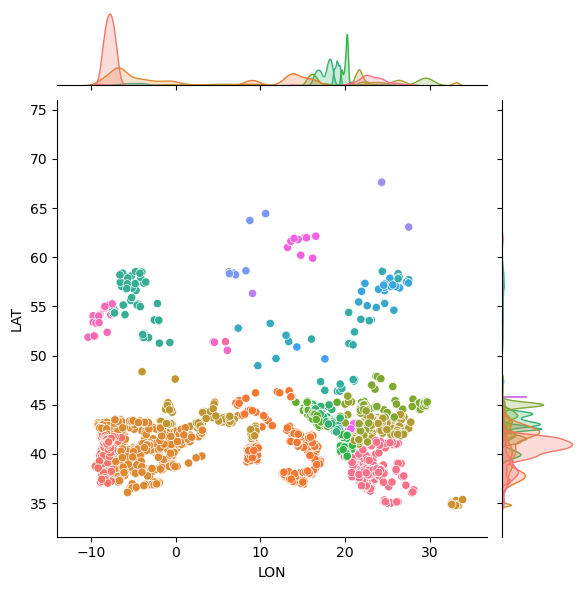

In [16]:
# Distribucion de GIF por países seleccionados

sns.jointplot(effis, x='LON', y='LAT', hue = 'COUNTRY', legend=False);
effis.COUNTRY.value_counts()

**AGRUPACIÓN POR PAÍSES**

GIF_GROUP
Balkans       1064
Portugal       976
Spain          690
Italy          430
Greece         300
Romania        184
Bulgaria       148
France         128
Otros          108
British_Is      94
Name: count, dtype: int64

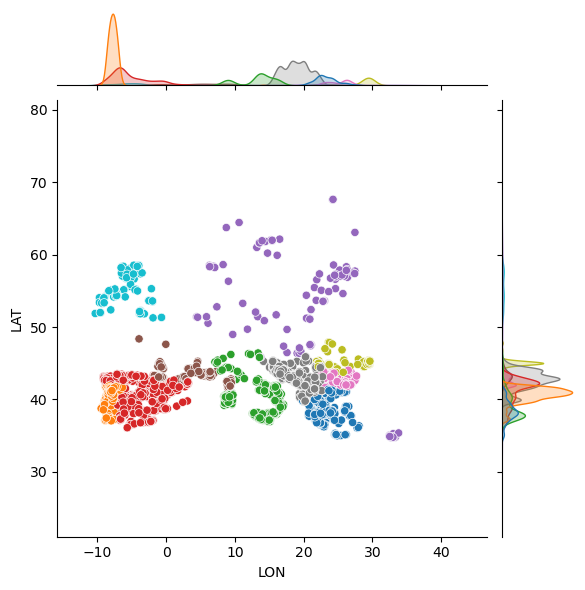

In [17]:
# Agrupamos los países para analizar más fácilmente los datos:

# Primero agrupamos los paises con menor número de incendios
seleccion = effis.COUNTRY.value_counts()
paises_min = seleccion[seleccion < 100].index

# Agrupamos los países de los Balcanes fuera de la UE + Croacia
balkans = ['North Macedonia', 'Serbia', 'Albania', 'Bosnia and Herzegovina', 'Montenegro', 'Kosovo', 'Croatia']

# También nos quedamos con el caso de las Islas Británicas
British_Is = ['United Kingdom','Ireland']

# Elimiamos los países redundantes de la lista 'paises_min' para evitar que los categorice com 'Otros'
pais_remove = []
for pais in paises_min:
    if (pais in balkans) or (pais in British_Is):
        pais_remove.append(pais)

paises_min = paises_min.drop(pais_remove)

# Creamos una nueva columna y renombramos los países
effis['GIF_GROUP'] = effis.COUNTRY.replace(paises_min, 'Otros')
effis['GIF_GROUP'] = effis.GIF_GROUP.replace(balkans, 'Balkans')
effis['GIF_GROUP'] = effis.GIF_GROUP.replace(British_Is, 'British_Is')

# Y echamos un vistazo a la distribución por países
sns.jointplot(effis, x='LON', y='LAT', hue = 'GIF_GROUP', legend=False);
effis.GIF_GROUP.value_counts()

**AGRUPACIÓN POR PROVINCIA**

Con esta agrupación se pretende evitar las fronteras administrativas, focalizándose en las zonas conretas dónde se producen los grandes incendios.  
Aquí intentaremos responder a la pregunta ¿dónde se producen los grandes incendios?

<Axes: >

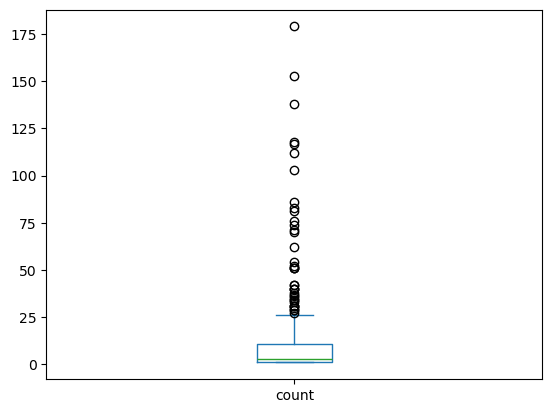

In [18]:
# Vistazo rápido a la distribución de número de incendios por zonas
# Nuevamente comprobamos que las zonas más afectadas suponen la cuarta parte de los datos, aproximadamente

effis.PROVINCE.value_counts().plot.box()

In [19]:
# Categorizamos las zonas por número de incendios: al haber una distribución tan grande (de 1 a >175) simplificamos usado una escala logarítmica
provincias = effis.PROVINCE.value_counts()

categorias = {}
for incendios, provincia in zip(provincias, provincias.index):
    categorias[provincia] = np.log(incendios).round().astype(int)

categorias

{'Beiras e Serra da Estrela': np.int64(5),
 '???? ????': np.int64(5),
 'Tulcea': np.int64(5),
 '???????': np.int64(5),
 '??????': np.int64(5),
 'Ourense': np.int64(5),
 'Douro': np.int64(5),
 'Korcë': np.int64(4),
 'Alto Tâmega': np.int64(4),
 'Viseu Dão Lafões': np.int64(4),
 '???????????': np.int64(4),
 '?????': np.int64(4),
 'Tâmega e Sousa': np.int64(4),
 'Palermo': np.int64(4),
 'Alto Minho': np.int64(4),
 'Médio Tejo': np.int64(4),
 'Agrigento': np.int64(4),
 'León': np.int64(4),
 'Zamora': np.int64(4),
 'Terras de Trás-os-Montes': np.int64(4),
 '????????': np.int64(4),
 'N.A.': np.int64(4),
 'Glamo?': np.int64(4),
 'Região de Coimbra': np.int64(4),
 'Cáceres': np.int64(4),
 'Beira Baixa': np.int64(4),
 '?????????': np.int64(4),
 'Ave': np.int64(4),
 'Splitsko-dalmatinska ?upanija': np.int64(4),
 'Trebinje': np.int64(4),
 '?ibensko-kninska ?upanija': np.int64(4),
 'Região de Leiria': np.int64(3),
 'Asturias': np.int64(3),
 'Durrës': np.int64(3),
 'Pontevedra': np.int64(3),
 'A Co

In [20]:
# Asignamos a cada incendio su categoría, creando para ello una nueva variable

for provincia, categoria in categorias.items():
    effis.loc[effis.PROVINCE == provincia, 'GIF_CAT'] = categoria

effis.GIF_CAT.value_counts()

GIF_CAT
4.0    1280
3.0    1007
5.0     920
2.0     551
1.0     248
0.0     116
Name: count, dtype: int64

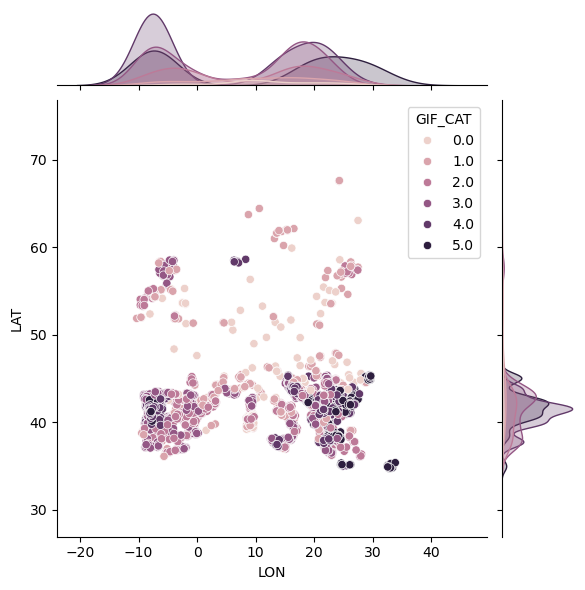

In [21]:
# Y echamos un vistazo a las 'zonas calientes'

sns.jointplot(effis, x='LON', y='LAT', hue = 'GIF_CAT', legend=True);

**DISTRIBUCIÓN EN EL TIEMPO**

En este apartado intentaremos responder a la pregunta ¿En qué época del año se producen los grandes incendios?

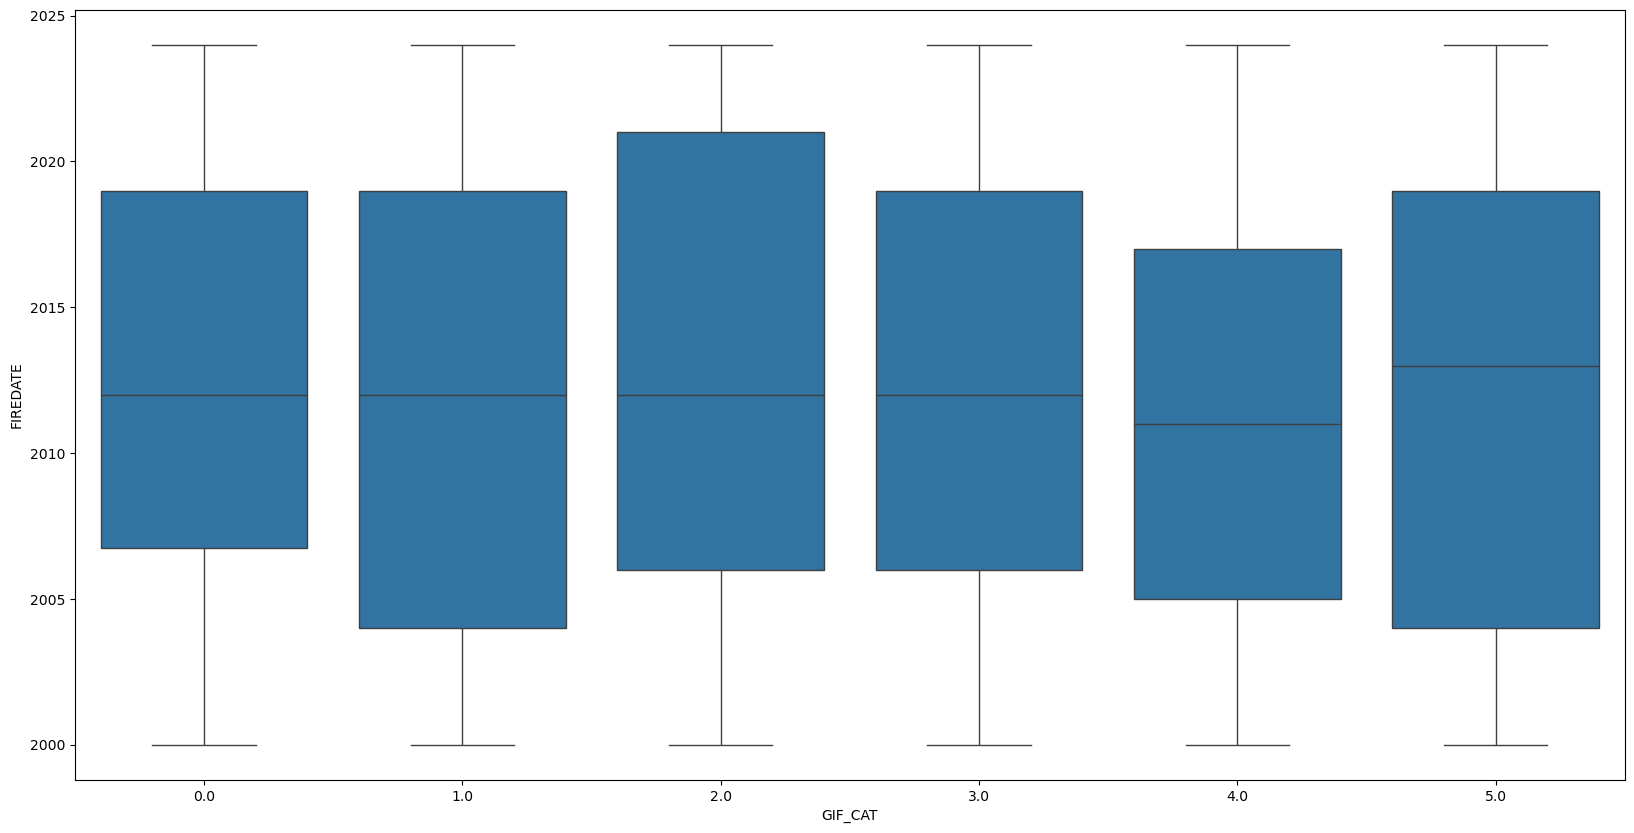

In [22]:
# Distribución por categorías. Aquí vemos que los datos están demasiado agrupados

plt.figure(figsize=(20, 10))
sns.boxplot(effis, x='GIF_CAT', y=effis.FIREDATE.dt.year);

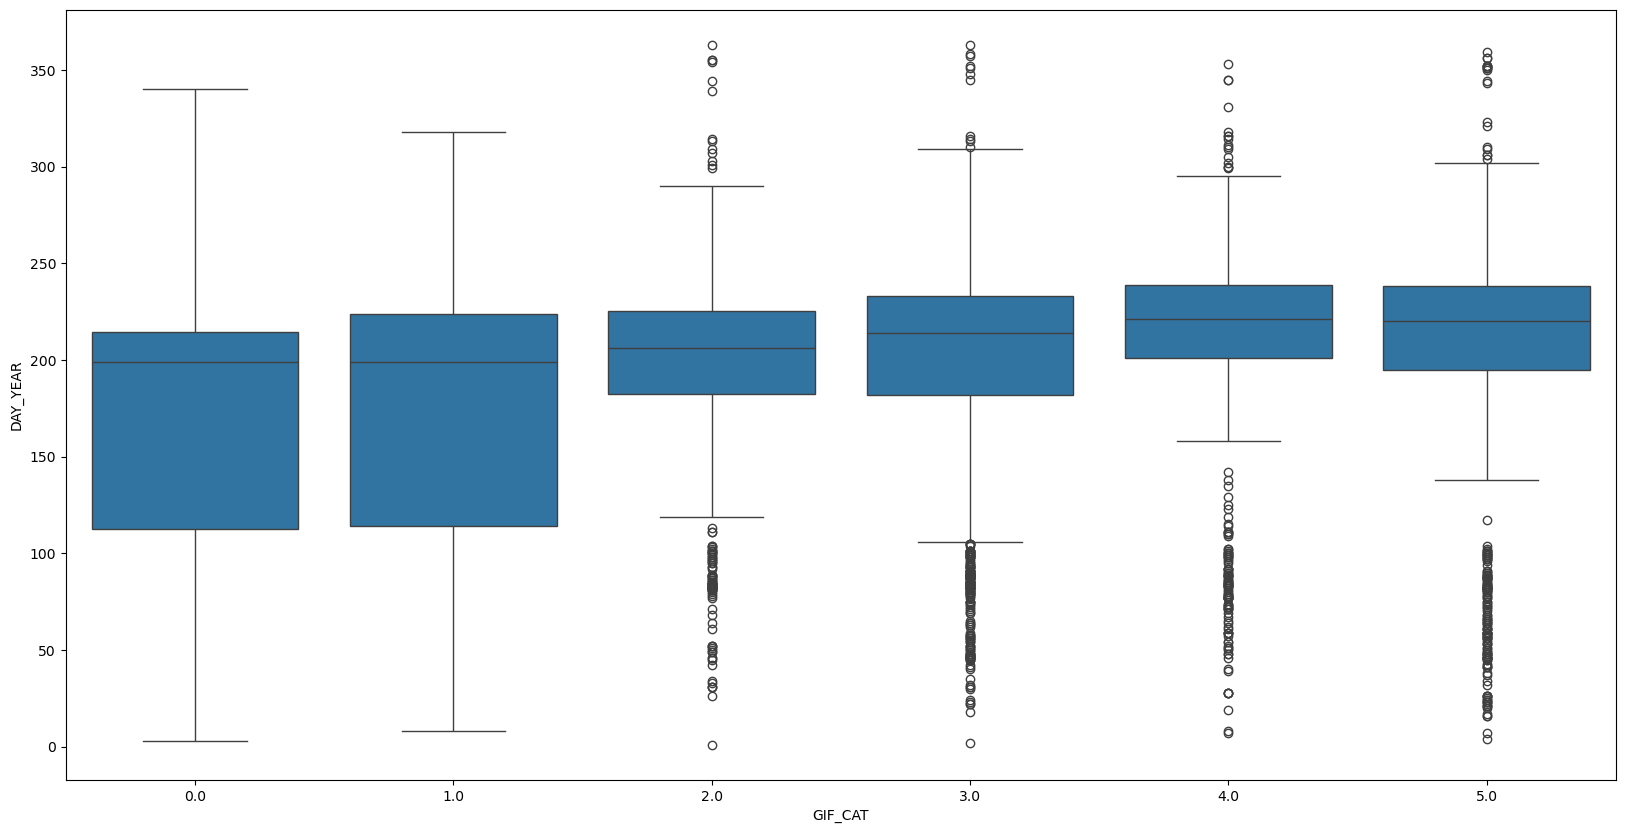

In [23]:
plt.figure(figsize=(20, 10))
sns.boxplot(effis, x='GIF_CAT', y='DAY_YEAR');

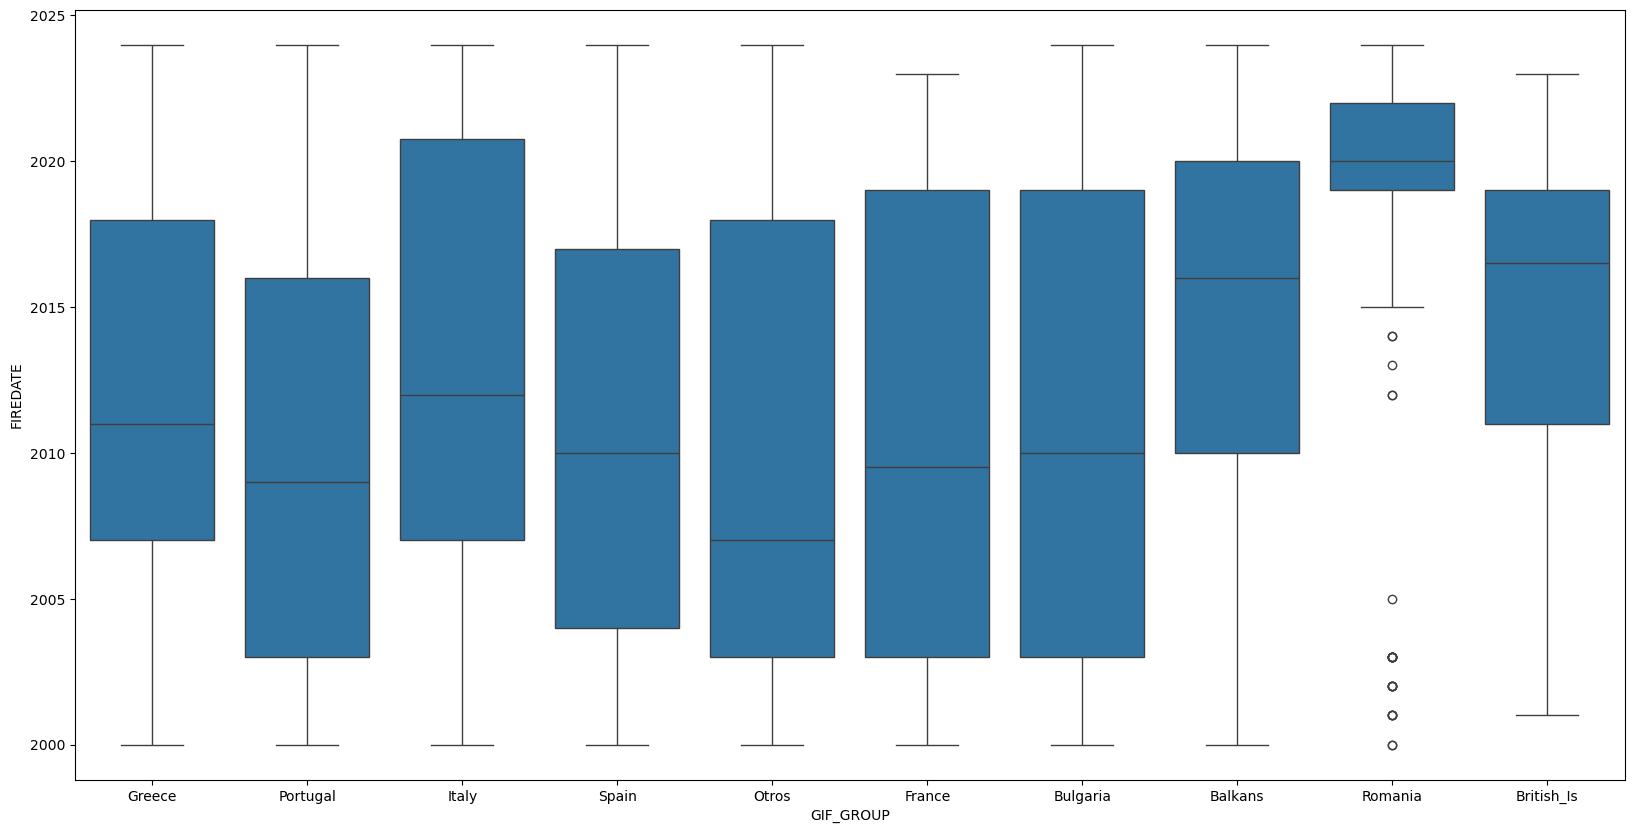

In [24]:
# Distribución por países. Aquí ya vemos por ejemplo que Rumanía tiene un 'problema' reciente, seguido de los Balcanes y las Islas Británicas 

plt.figure(figsize=(20, 10))
sns.boxplot(effis, x='GIF_GROUP', y=effis.FIREDATE.dt.year);

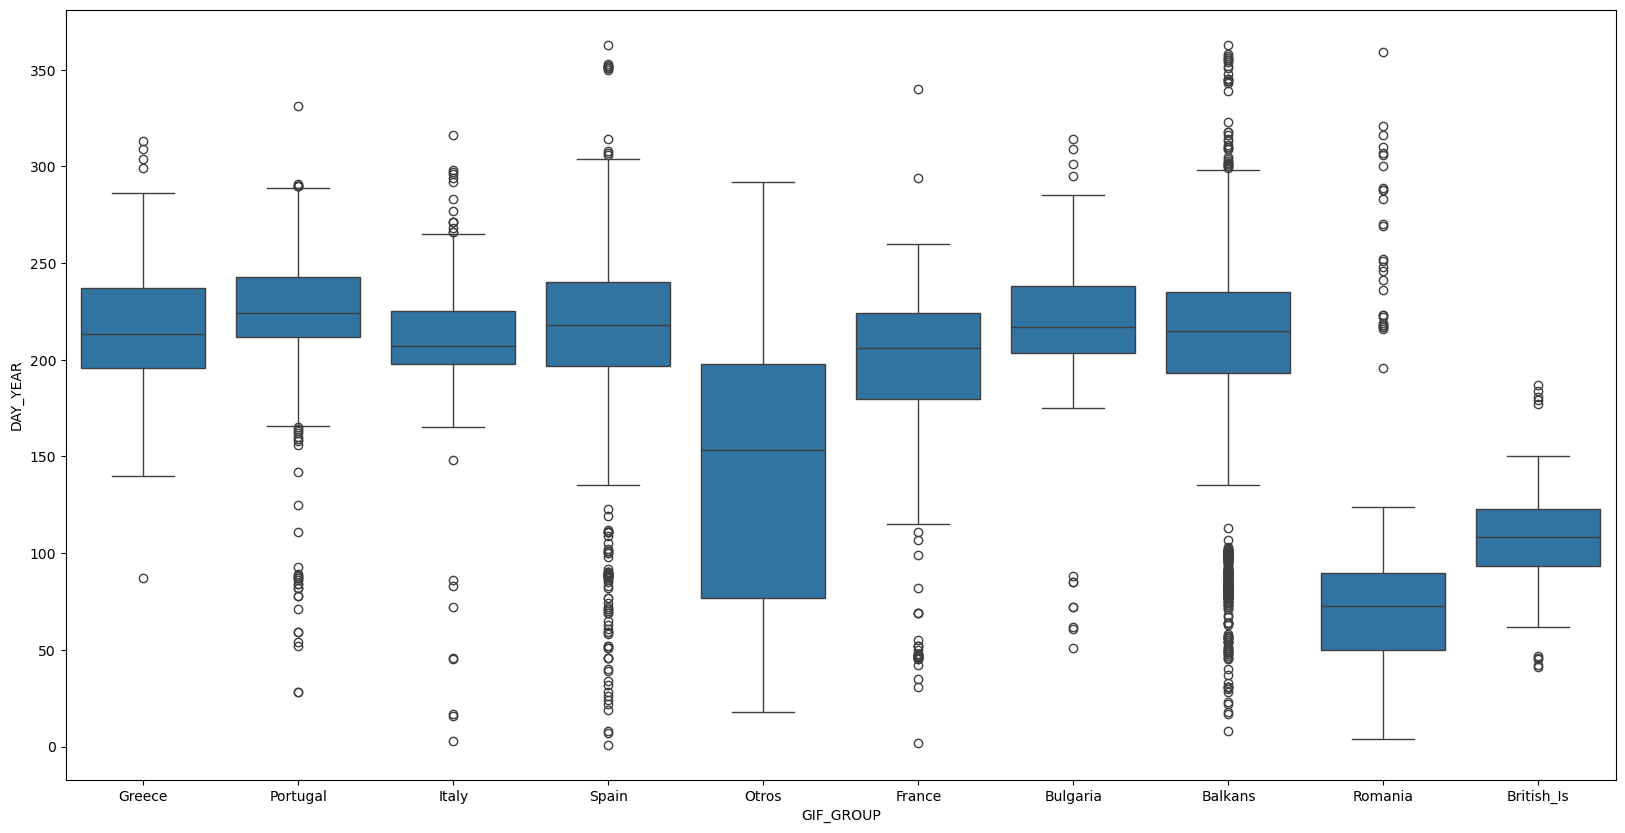

In [25]:
plt.figure(figsize=(20, 10))
sns.boxplot(effis, x='GIF_GROUP', y='DAY_YEAR');

In [26]:
# Vamos a intentar  delimitar  el período de primavera
# Para ello, usaremos de modelo  a Rumanía e Islas Britanicas  frente  al resto de países 
# (a salvedad del grupo 'Otros' que quedará al margen debido a su amplitud)

std_epoca = effis.groupby('GIF_GROUP')['DAY_YEAR'].describe()
std_epoca['IQR'] = std_epoca['75%'] - std_epoca['25%']
std_epoca.sort_values('25%')

,count,mean,std,min,25%,50%,75%,max,IQR
GIF_GROUP,,,,,,,,,
Romania,184.0,94.673913,76.900064,4.0,49.75,72.5,89.50,359.0,39.75
Otros,108.0,144.481481,63.729346,18.0,77.00,153.5,198.00,292.0,121.00
British_Is,94.0,108.734043,27.674054,41.0,93.25,108.5,122.75,187.0,29.50
France,128.0,179.546875,72.789510,2.0,179.75,206.0,224.00,340.0,44.25
Balkans,1064.0,194.067669,67.815359,8.0,193.00,215.0,235.00,363.0,42.00
Greece,300.0,215.506667,27.986678,87.0,195.75,213.5,237.00,313.0,41.25
Spain,690.0,209.614493,58.571300,1.0,197.00,218.0,240.00,363.0,43.00
Italy,430.0,209.623256,32.689005,3.0,198.00,207.0,225.00,316.0,27.00
Bulgaria,148.0,215.216216,42.298026,51.0,203.75,217.0,238.00,314.0,34.25


In [27]:
# Establecemos los límites del período de grandes incendios en verano en función de Portugal, 
# que es el que tiene la distribución más retrasada además de contar con el mayor número de grandes incendios

pais_verano = std_epoca[std_epoca.index == 'Portugal']
lim_verano = [round(pais_verano['25%'].iloc[0] - 1.25*pais_verano['IQR'].iloc[0]),round(pais_verano['75%'].iloc[0] + 1.25*pais_verano['IQR'].iloc[0])]

lim_verano

[173, 282]

In [31]:
# Ahora vamos a ver la distribución de incendios fuera del período estival que hemos definido
# Para ello consideraremos los días un continuo desde 'otoño' hasta nuestro 'verano'

effis_inv = effis[(effis.DAY_YEAR < lim_verano[0]) | (effis.DAY_YEAR > lim_verano[1])]

def anti_juliano(dia):
    anti_dia = dia - 360 if dia > lim_verano[1] else dia
    return anti_dia

effis_inv.DAY_YEAR = effis_inv.DAY_YEAR.apply(anti_juliano)

/usr/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,count,mean,std,min,25%,50%,75%,max,IQR
GIF_GROUP,,,,,,,,,
France,33.0,54.030303,39.948783,-66.0,46.0,48.0,69.00,170.0,23.00
British_Is,89.0,104.640449,22.136584,41.0,93.0,106.0,122.00,150.0,29.00
Romania,166.0,55.891566,37.790976,-77.0,46.0,61.0,82.75,124.0,36.75
Balkans,285.0,61.108772,47.223309,-74.0,51.0,81.0,90.00,135.0,39.00
Otros,66.0,98.515152,43.954257,-68.0,72.0,98.0,119.25,171.0,47.25
Bulgaria,13.0,21.538462,67.543338,-75.0,-51.0,61.0,72.00,88.0,123.00
Spain,169.0,47.846154,87.471900,-76.0,-57.0,69.0,111.00,172.0,168.00
Greece,18.0,98.166667,101.548163,-74.0,-13.5,159.0,168.00,172.0,181.50
Italy,23.0,54.565217,96.838115,-77.0,-53.0,46.0,166.50,172.0,219.50


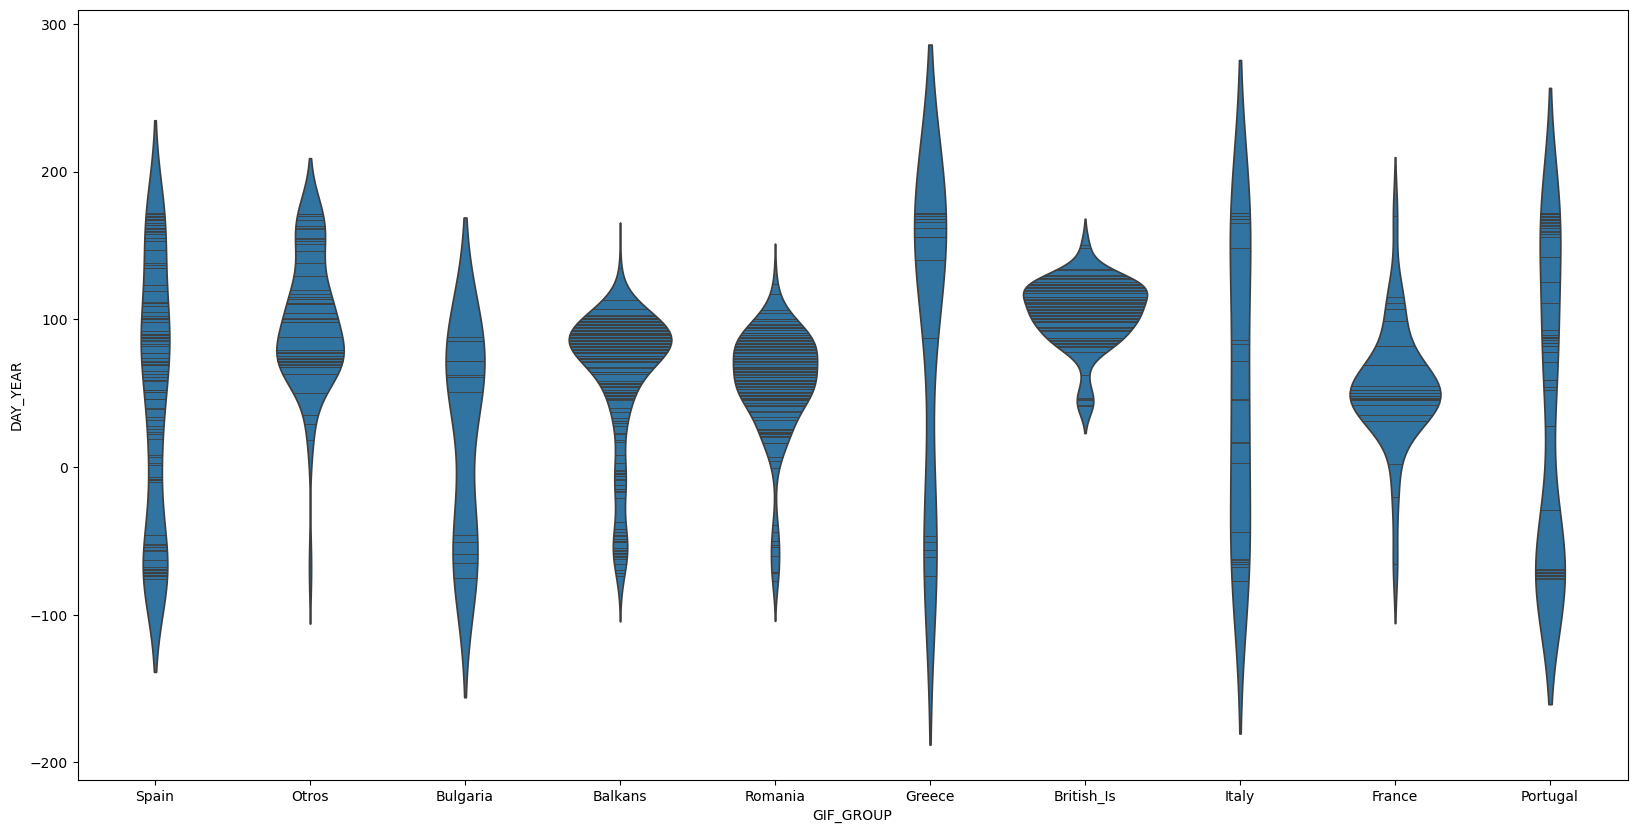

In [60]:
# En este caso, debido al menor numero de incendios y su distribución más homogénea en algunos casos, usaremos un diagrama de violin
# Podemos apreciar que los países de los Balcanes, Rumanía e Islas Británicas si tienen un período más marcado
# Además, son los países con mayor número de GIF en este período, salvo España y Portugal,
# los cuáles no tienen un período tan claro y sí un número mucho mayor de GIFs en general

plt.figure(figsize=(20, 10))
sns.violinplot(effis_inv, x='GIF_GROUP', y='DAY_YEAR', inner='sticks')
std_inv = effis_inv.groupby('GIF_GROUP')['DAY_YEAR'].describe()
std_inv['IQR'] = std_inv['75%'] - std_inv['25%']
std_inv.sort_values('IQR')

In [53]:
# Establecemos los límites del período de grandes incendios en invierno en función de Rumanía

pais_inv = std_epoca[std_epoca.index == 'Romania']
lim_inv = [round(pais_inv['25%'].iloc[0] - 1.25*pais_inv['IQR'].iloc[0]),round(pais_inv['75%'].iloc[0] + 1.25*pais_inv['IQR'].iloc[0])]

lim_inv

[0, 139]

In [58]:
# Comprobamos a qué días del calendario corresponden los días julianos calculados

def fecha_juliano(dia_juliano):
    dias_meses = [0,31,29,31,30,31,30,31,31,30,31,30]
    resto = dia_juliano
    for index, dias in enumerate(dias_meses):
        if resto - dias < 0:
            return f'{resto}/{index}'
            break
        resto = resto - dias

for string, dia in zip(['Inicio','Fin'],lim_verano):
    print(f'{string} verano:\t{fecha_juliano(dia)}')

for string, dia in zip(['Inicio','Fin'],lim_inv):
    print(f'{string} inv:\t{fecha_juliano(dia)}')

Inicio verano:	21/6
Fin verano:	8/10
Inicio inv:	0/1
Fin inv:	18/5


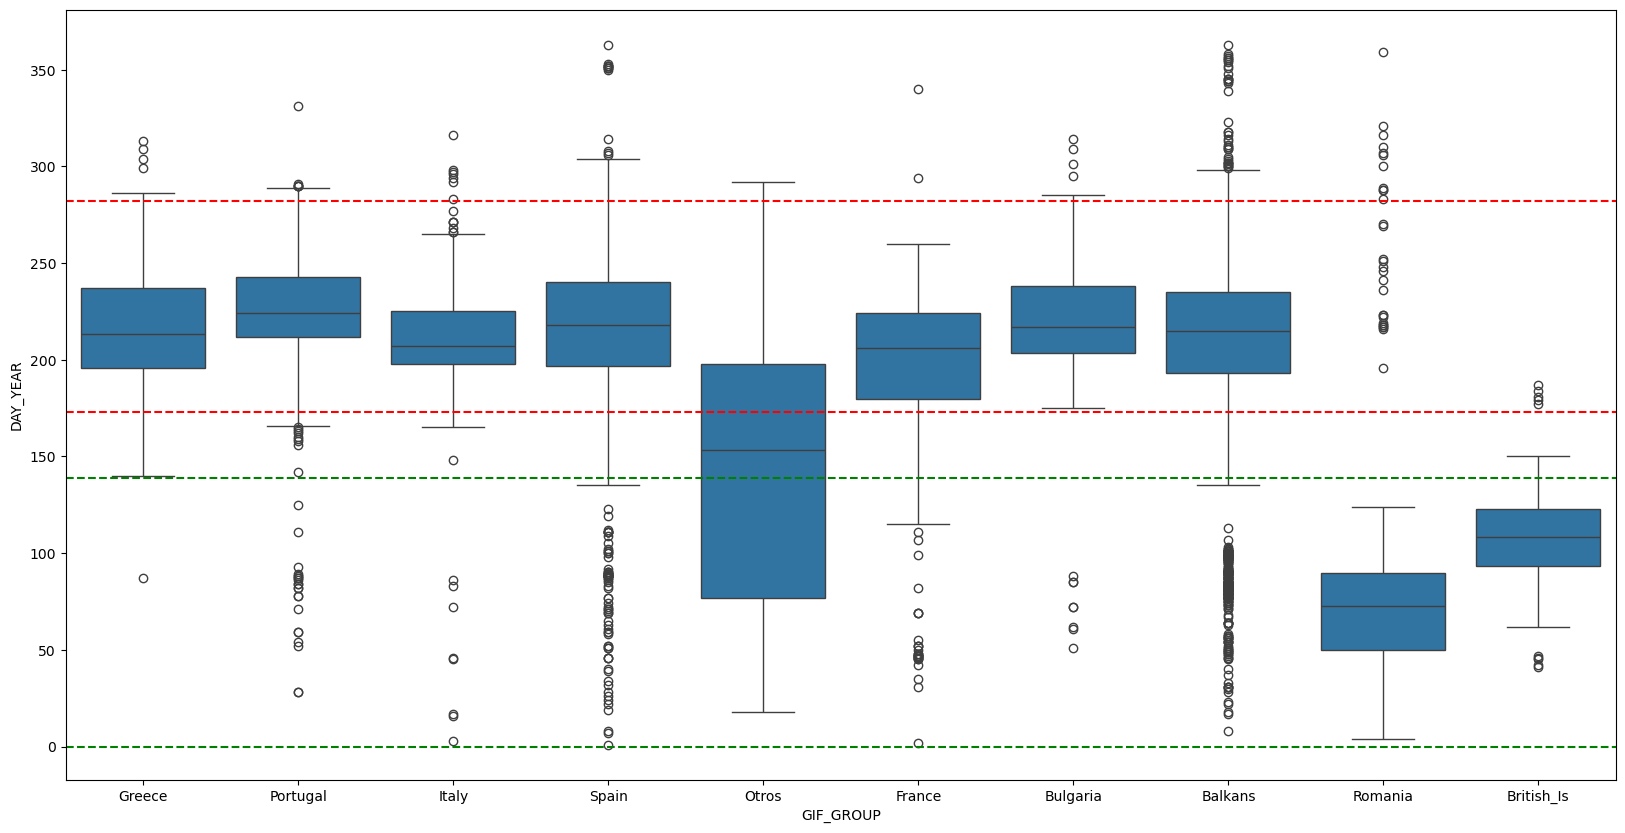

In [56]:
plt.figure(figsize=(20, 10))
sns.boxplot(effis, x='GIF_GROUP', y='DAY_YEAR')
plt.axhline(y=lim_verano[0], color='r', linestyle='--')
plt.axhline(y=lim_verano[1], color='r', linestyle='--')
plt.axhline(y=lim_inv[0], color='g', linestyle='--')
plt.axhline(y=lim_inv[1], color='g', linestyle='--');

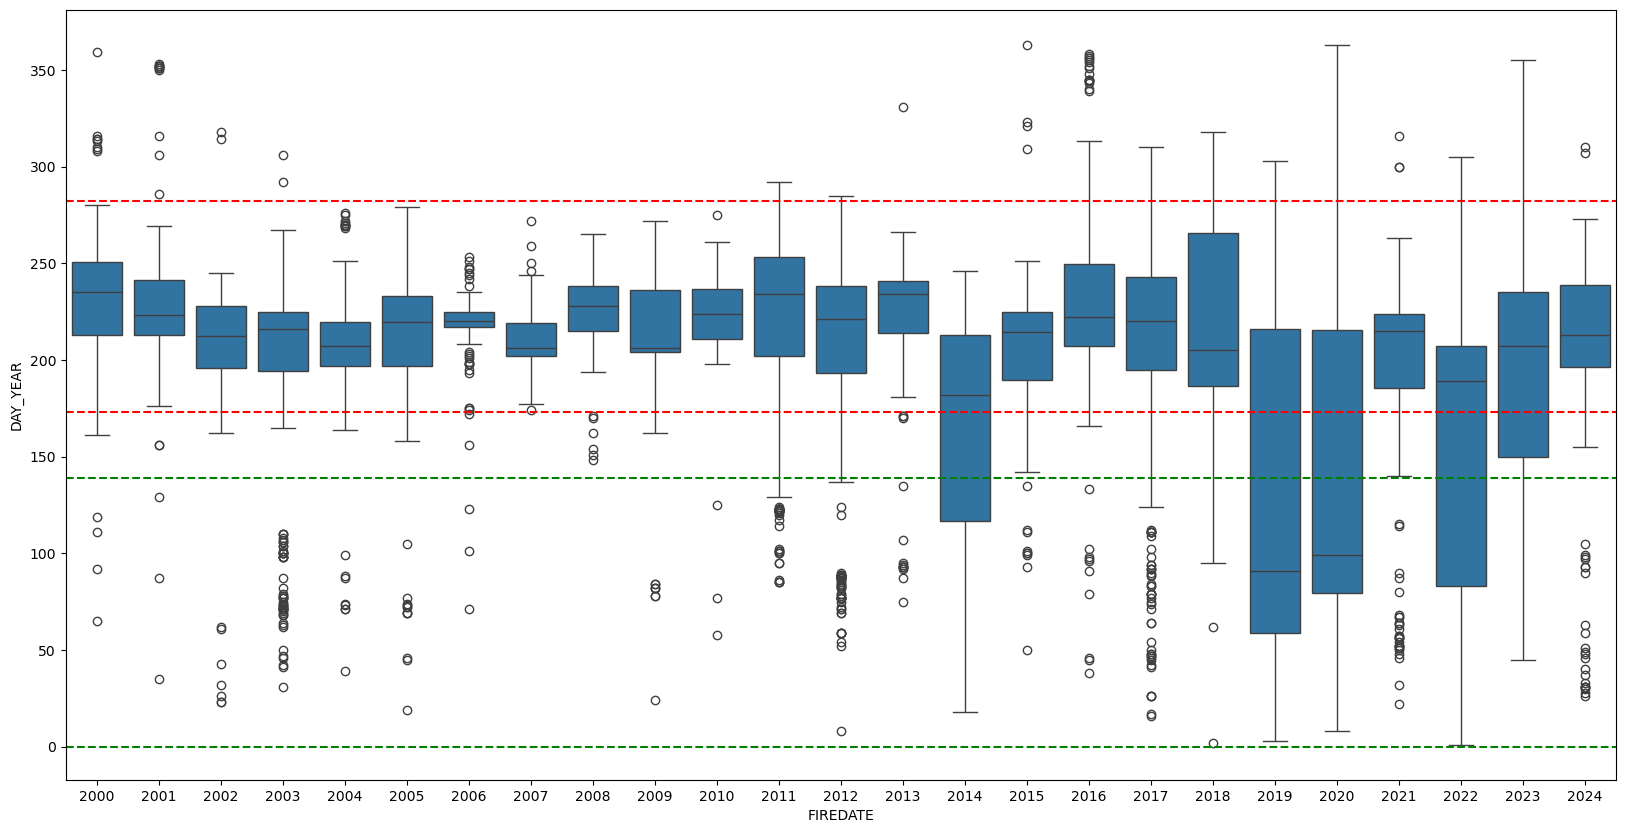

In [64]:
# Distribución de número de grandes incendios por día juliano para cada año
# Aquí podemos ver cómo la ventana de los grandes incendios se va ampliando hacia la primavera

plt.figure(figsize=(20, 10))
sns.boxplot(effis, x=effis.FIREDATE.dt.year, y=effis.DAY_YEAR)
plt.axhline(y=lim_verano[0], color='r', linestyle='--')
plt.axhline(y=lim_verano[1], color='r', linestyle='--')
plt.axhline(y=lim_inv[0], color='g', linestyle='--')
plt.axhline(y=lim_inv[1], color='g', linestyle='--');